# ML- PS3, Juan Arroyo Miranda


In [1]:
%matplotlib inline
%run classify
sns.set_style('whitegrid')

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Part 1, Fixing Processing of Data

In [2]:
df = read_files.read_data('credit-data.csv')

## Data summary

### In order to understand what factors make individuals more likely to not pay debt, I computed the following  summary statistics for the data set: mean, mode, and missing data

In [3]:
df.mean()

personid                                75000.500000
seriousdlqin2yrs                            0.066840
revolvingutilizationofunsecuredlines        6.048438
age                                        52.295207
zipcode                                 60648.810013
numberoftime30-59dayspastduenotworse        0.421033
debtratio                                 353.005076
monthlyincome                            6670.221237
numberofopencreditlinesandloans             8.452760
numberoftimes90dayslate                     0.265973
numberrealestateloansorlines                1.018240
numberoftime60-89dayspastduenotworse        0.240387
numberofdependents                          0.757222
dtype: float64

In [4]:
df.mode().unstack()

personid                              0        NaN
seriousdlqin2yrs                      0        0.0
revolvingutilizationofunsecuredlines  0        0.0
age                                   0       49.0
zipcode                               0    60625.0
numberoftime30-59dayspastduenotworse  0        0.0
debtratio                             0        0.0
monthlyincome                         0     5000.0
numberofopencreditlinesandloans       0        6.0
numberoftimes90dayslate               0        0.0
numberrealestateloansorlines          0        0.0
numberoftime60-89dayspastduenotworse  0        0.0
numberofdependents                    0        0.0
dtype: float64

### Two variables have missing values that will be necessary to impute: monthly income and number of dependents.

In [5]:
process_data.percentage_missing(df)

19.8% missing from: Column monthlyincome
2.6% missing from: Column numberofdependents


## Analysis for Number of Dependents

To decide how to impute the data for the number of dependents I created a function that does two things. First, it calculates the cumulative sum of the value counts for each possible group in number of dependents. Second, it computes the percentage of the observations that fall in each one of these groups.

In [6]:
process_data.des_num_dep(df)

,numberofdependents,Cumulative_Sum,Percentage_By_Group
0.0,86902,86902,59.490950
1.0,26316,113218,77.506230
2.0,19522,132740,90.870506
3.0,9483,142223,97.362332
4.0,2862,145085,99.321586
5.0,746,145831,99.832279
6.0,158,145989,99.940442
7.0,51,146040,99.975355
8.0,24,146064,99.991785
9.0,5,146069,99.995208


## Tables are nice, but some visualization is in order

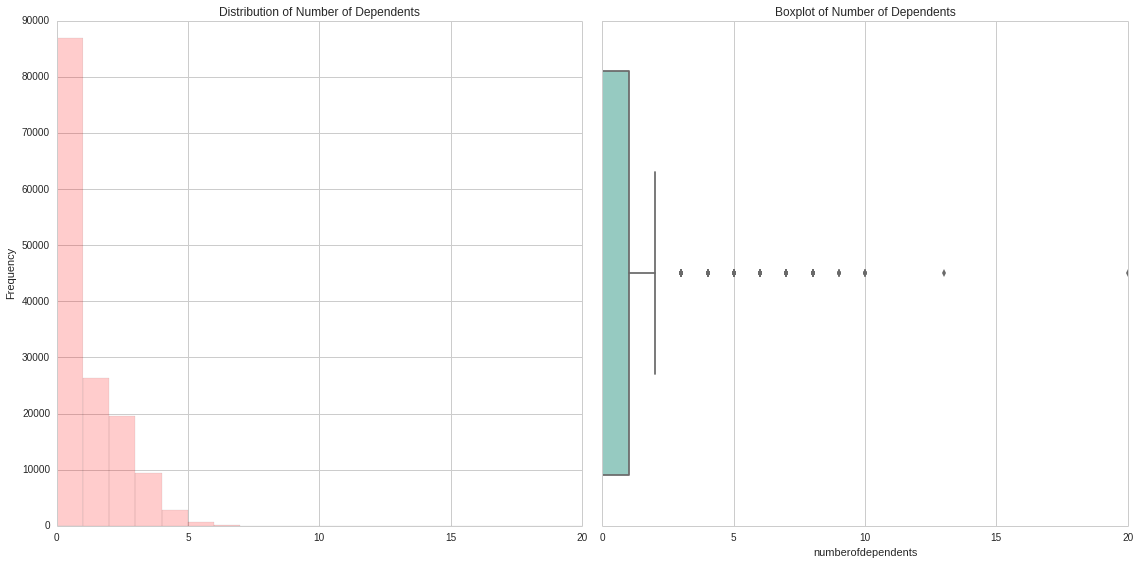

In [7]:
process_data.frequency_plots(df, 'numberofdependents')

The plots show that the distribution of the number of dependents is skewed to the right, with most people
(86,902) having zero dependents. The boxplot shows the presence of some outliers, however, 90.87 % of
the population concentrates between 0 and 2 dependents. Therefore, it would be reasonable to impute
dependents drawn randomly between 0 and 2. While performing this imputation, I will take into account the
frequencies observed in the data for groups 0, 1, and 2.

## Analysis for Monthly Income

In [8]:
print(df['monthlyincome'].describe(include = 'all'))

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: monthlyincome, dtype: float64


This general description of the monthly income variable provides some insights about the distribution of the data. The first thing that caught my attention was the jump between the third quartile (\$ 8,249) and the maximum (\$3,008,750). I decided to take a look at the deciles to gain a better understanding of this variable

### Pandas default method for computing percentiles does not take Nan values into account!!!

Using numpy's percentile function made me realize that I was getting different values from the ones computed by pandas' describe function. There are two interesting results from computing the deciles for monthly income:
1. The 80th percentile changes from \$9,083 using nanpercentile function to \$54,166 using a function that takes into account the Nan values.
2. Most Nan observations come from the highest percentiles in the income distribution

In [9]:
# Income deciles is a better description of the data (ignoring nan)
for i in range(10,101,5):
 print(i, 'Nan percentile', np.nanpercentile(df['monthlyincome'], i), "|", 'percentile', np.percentile(df['monthlyincome'], i) )


10 Nan percentile 2005.0 | percentile 2325.0
15 Nan percentile 2500.0 | percentile 2904.0
20 Nan percentile 3000.0 | percentile 3400.0
25 Nan percentile 3400.0 | percentile 3903.0
30 Nan percentile 3800.0 | percentile 4333.0
35 Nan percentile 4166.0 | percentile 4906.0
40 Nan percentile 4544.2 | percentile 5400.0
45 Nan percentile 5000.0 | percentile 6000.0
50 Nan percentile 5400.0 | percentile 6600.0
55 Nan percentile 5855.0 | percentile 7339.0
60 Nan percentile 6300.0 | percentile 8200.0
65 Nan percentile 6916.0 | percentile 9318.0
70 Nan percentile 7500.0 | percentile 10660.0
75 Nan percentile 8249.0 | percentile 13333.0
80 Nan percentile 9083.0 | percentile 54166.0
85 Nan percentile 10100.0 | percentile nan
90 Nan percentile 11666.0 | percentile nan
95 Nan percentile 14587.6 | percentile nan
100 Nan percentile 3008750.0 | percentile nan


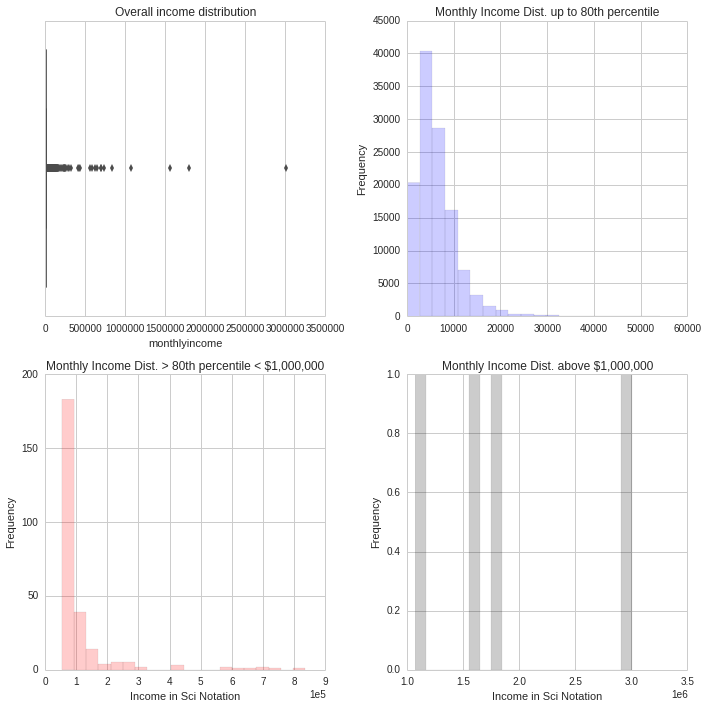

In [10]:
process_data.plot_income_distribution(df, 'monthlyincome')

As expected, the monthly income distribution is asymmetric. We can observe this once we divide the distribution by deciles. The first plot (right top corner) shows the income distribution up to the 80th percentile, from this plot, it is clear that most people earn less than \$10,000 per month.
Above the 80th percentile and below $1,000,000, we observe the same pattern with most people earning around \$100,000 per month.
It is interesting to note that the percentile function returns nan (versus nanpercentile function) for percentiles equal to and above the 85th percentile. This might suggest that the richest people in the sample tend not to report their monthly income.

Since we have 29,731 missing values, it might safe to assume that they come from the average population and not from the outliers. Therefore, I decided to impute the data with the mean value.

## Splitting Data and doing imputation

In [11]:
# Data imputation for Number of Dependents
process_data.impute_val_to_column(df,'numberofdependents', 'random', 0, 3, [0.65,0.2,0.15])

In [12]:
# Impute income data
process_data.impute_val_to_column(df,'monthlyincome', 'mean')

In [13]:
df['age'].replace(0, df['age'].mean(), inplace = True)

### Check imputation was done correctly

In [14]:
df.isnull().sum()

personid                                0
seriousdlqin2yrs                        0
revolvingutilizationofunsecuredlines    0
age                                     0
zipcode                                 0
numberoftime30-59dayspastduenotworse    0
debtratio                               0
monthlyincome                           0
numberofopencreditlinesandloans         0
numberoftimes90dayslate                 0
numberrealestateloansorlines            0
numberoftime60-89dayspastduenotworse    0
numberofdependents                      0
dtype: int64

## Discretize and Visualize data by buckets

In [15]:
bins_income = range(0, 100000, 5000)
bins_age = range(20,120,5)
income_bucket = process_data.discretize(df, 'monthlyincome', bins_income)
age_bucket = process_data.discretize(df, 'age', bins_age)

### In the following subplots, I explore some relationships that seem intuitive at first glance. For example, we expect that Seriousdlqin2yrs is positively correlated with the number of dependents, since having more children may difficult the payment of debts.

### By dividing the mothly income into buckets, we incorporate our findings from the percentile distribution. Since most observations are within the 0 and 100, 000 usd, I chose not to incorporate outliers in this graph. It is interesting to note that the highest financial distress in for people with an income of \$100,000.

### Two curious facts abouts the age buckets:
### 1. People between 25 and 30 years are more likely not to pay their debts, also people between 95 and 100.
### 2. The highest debt to income rage is for 95 - 100 group.

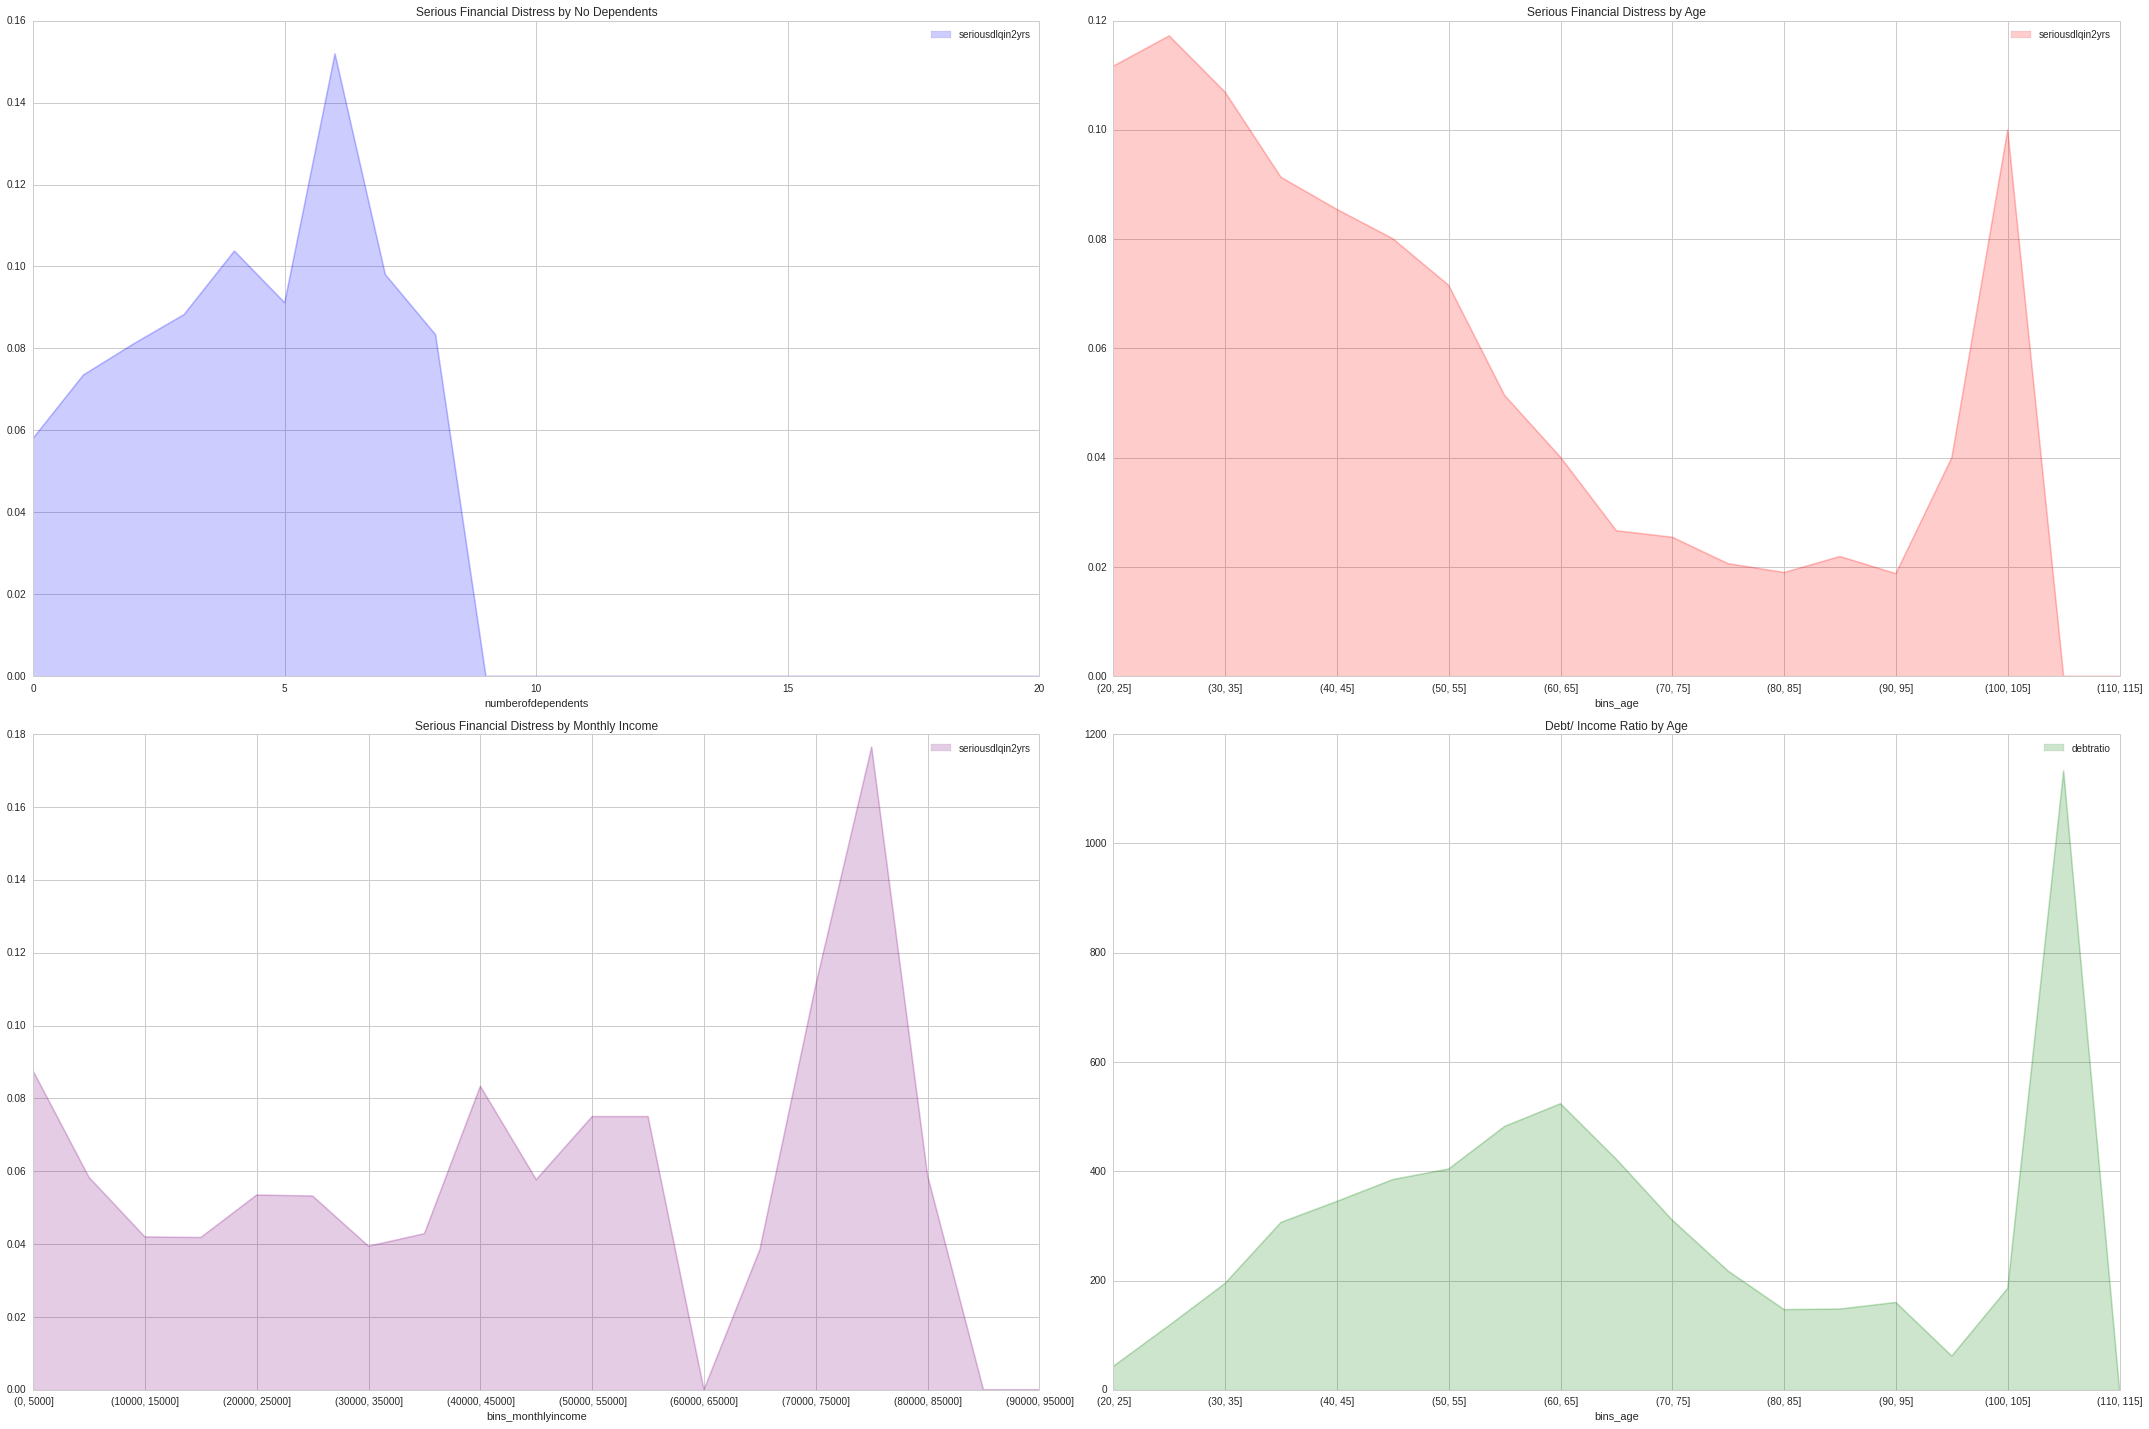

In [16]:
process_data.visualize_buckets(df, 'numberofdependents', 'seriousdlqin2yrs', 'debtratio', 'bins_age', 'bins_monthlyincome')

Looking at the income graph, it is easy to observe a high variability in the data. This variability will 'contaminate' with noise our prediction. Normalization is one way to handle this issue. 

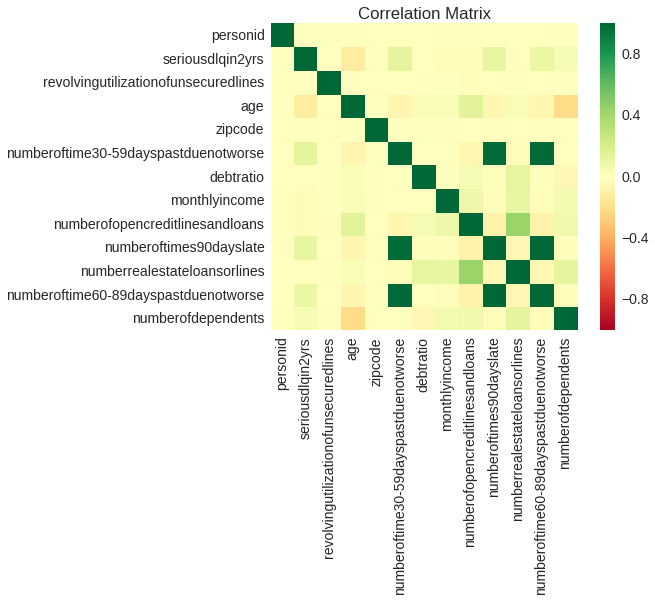

In [17]:
process_data.plot_corr_matrix(df)

## Categorical to Dummy

In [18]:
df['zipcode'].astype("category")
process_data.dummify(df, 'zipcode').tail()

,personid,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,zipcode,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,...,bins_monthlyincome,bins_age,60601,60618,60625,60629,60637,60644,60657,60804
149995,149996,0,0.040674,74.0,60637,0,0.225131,2100.000000,4,0,...,"(0, 5000]","(70, 75]",0,0,0,0,1,0,0,0
149996,149997,0,0.299745,44.0,60625,0,0.716562,5584.000000,4,0,...,"(5000, 10000]","(40, 45]",0,0,1,0,0,0,0,0
149997,149998,0,0.246044,58.0,60625,0,3870.000000,6670.221237,18,0,...,"(5000, 10000]","(55, 60]",0,0,1,0,0,0,0,0
149998,149999,0,0.000000,30.0,60625,0,0.000000,5716.000000,4,0,...,"(5000, 10000]","(25, 30]",0,0,1,0,0,0,0,0
149999,150000,0,0.850283,64.0,60657,0,0.249908,8158.000000,8,0,...,"(5000, 10000]","(60, 65]",0,0,0,0,0,0,1,0


In [19]:
df = df.drop(['bins_age', 'bins_monthlyincome'], axis =1)

# Parts 2 - 4, Model Selection and Implementation

### Normalize data with high variance

In [20]:
# Normalize income data 
df['monthlyincome'] = StandardScaler().fit_transform(df['monthlyincome'])
# Normalize revolving utilization of unsecured lines
df['revolvingutilizationofunsecuredlines'] = StandardScaler().fit_transform(df['revolvingutilizationofunsecuredlines'])

In [21]:
y = df['seriousdlqin2yrs'].values
X = df.drop('seriousdlqin2yrs', axis=1).values

## Part 2: Adding Classifiers

### In the following part, I call the do_learning function which implements a modified version of Rayid Ghani's magic loop function to run different classifiers and parameter combinations.

### The models  to run are : Logistic Regression,  Knn, Decision Tree, Random Forests, Boosting, Bagging, and Linear SVM

In [22]:
features  =  ['numberoftime30-59dayspastduenotworse', 
              'monthlyincome', 'numberrealestateloansorlines', 'numberofdependents']

models_to_run=['LR','KNN','DT', 'RF', 'AB','GB','LSVC']

## Part 3: Defining Parameter Grids

In [26]:
    test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LSVC' :{'C' :[0.01]},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }

In [27]:
    small_grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'ET': { 'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'LSVC' :{'penalty': ['l1','l2'], 'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }

## Part 4 and 5: Metrics, Plots and Comparison Table

### I decided to call the do_learning function with the test parameter grid for simplicity, but the small grid can be used as well. The function also produces precision-recall plots for each model and each parameter combination.

### Finally, the do_learning function stores the results in a CSV file which contains the model's especifications and metrics at different threshold levels.

LR


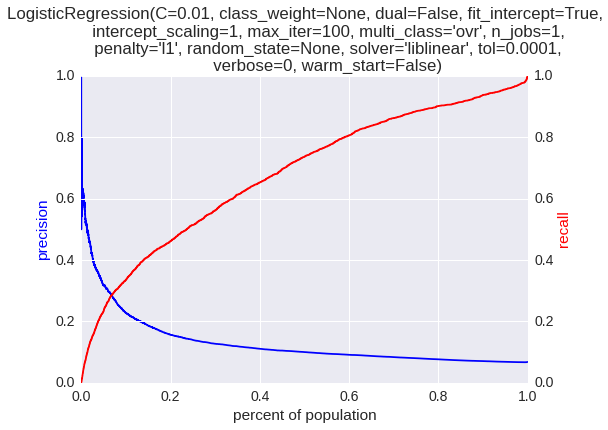

KNN


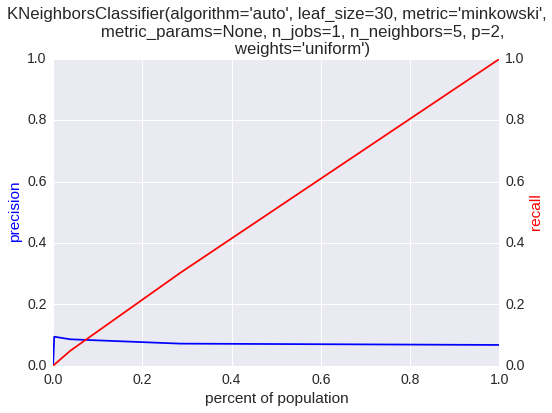

DT


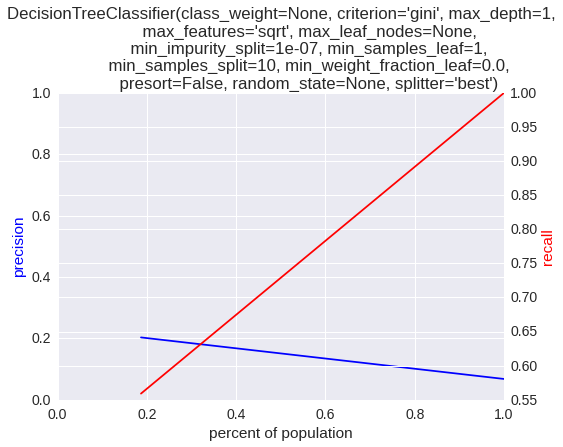

RF


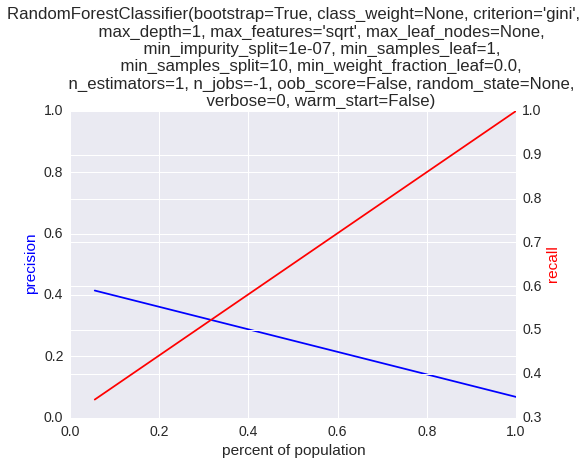

AB


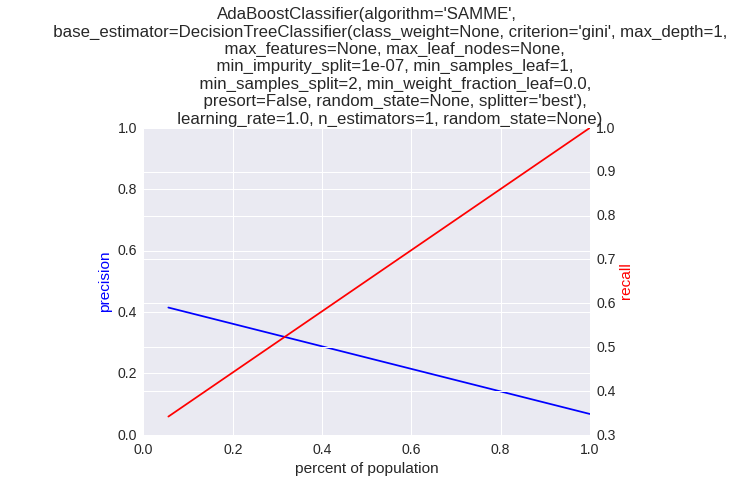

GB


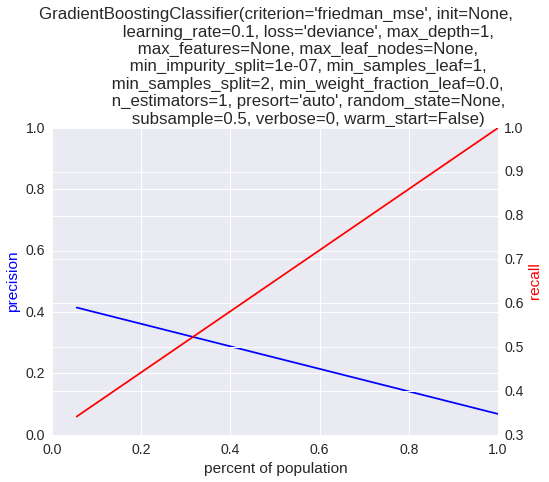

LSVC


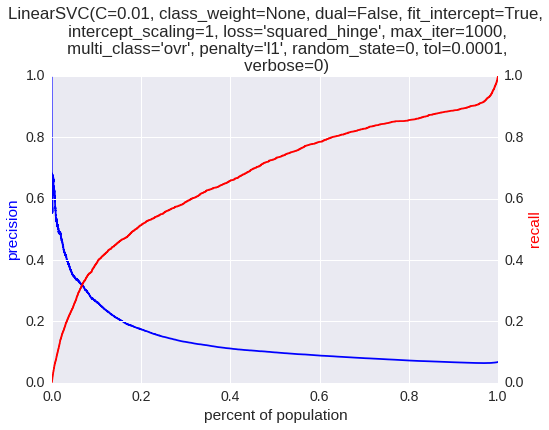

In [23]:
results, matrix = do_learning(models_to_run, features, 'test', X, y)

### It is clear that the test grid produces terrible results in terms of predicition, but this can be improved using the small grid.

## Confusion Party

### As an additional tool for model comparison, I created the following subplots for the confusion matrix for each model

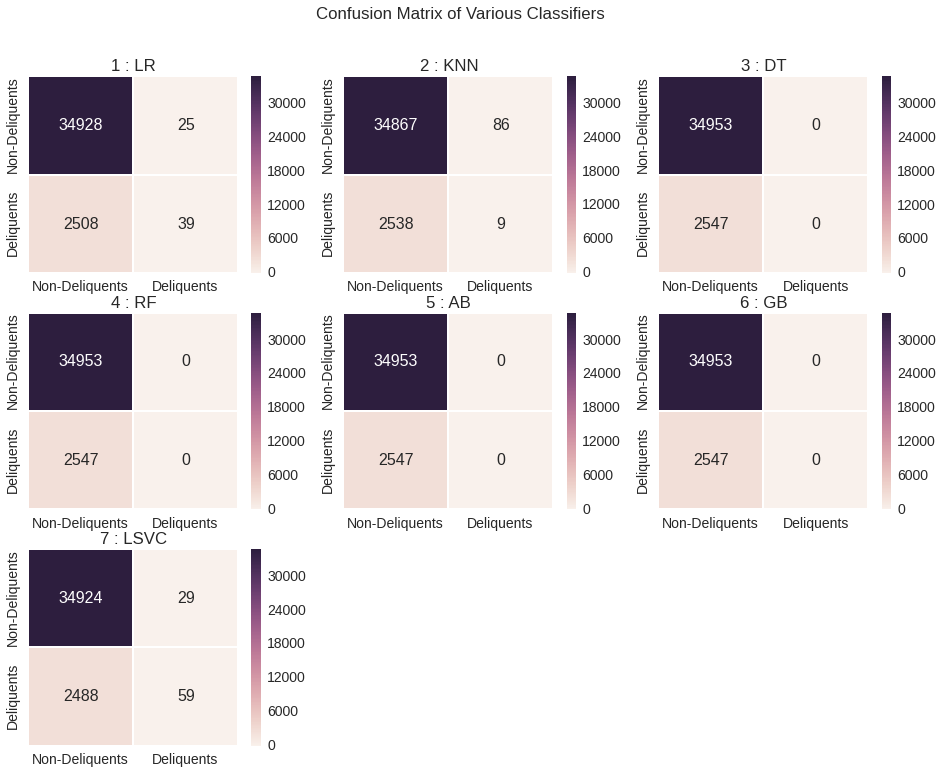

In [24]:
confusion_party(matrix, ['Non-Deliquents', 'Deliquents'])

## Results Data Frame

In [25]:
results.head()

,model_type,clf,parameters,train_time,predict_time,auc-roc,p_at_5,p_at_10,p_at_20,r_at_5,r_at_10,r_at_20,f1_at_5,f1_at_10,f1_at_20
0,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",10.088636,6.570123,0.694143,0.317867,0.227733,0.156667,0.234001,0.335296,0.461327,0.269561,0.271240,0.233901
1,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'weights': 'uniform', 'n...",1.875406,5.135943,0.510898,0.294933,0.205867,0.102933,0.217118,0.303102,0.303102,0.250113,0.245196,0.153678
2,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 10, 'criterion': 'gini',...",0.133421,0.189233,0.699694,0.759467,0.379733,0.255733,0.559089,0.559089,0.753043,0.644052,0.452279,0.381806
3,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'min_samples_split': 10, 'max_depth': 1, 'n_e...",0.257245,0.257204,0.653223,0.464000,0.672533,0.339600,0.341578,0.990185,1.000000,0.393487,0.801016,0.507017
4,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'algorithm': 'SAMME'}",0.370975,0.415902,0.653223,0.464000,0.672533,0.339600,0.341578,0.990185,1.000000,0.393487,0.801016,0.507017
